## Question 1

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

from tabulate import tabulate ##Tables

# PUT YOUR IMPLEMENTATION HERE. Take inspiration from the "minimal notebook" that was sent to you. 
theta = 0.3 #We take theta=0.3
prog = Program() 
q = prog.qalloc(2)
prog.apply(H, q[0])
def matrix(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)
ham_x = AbstractGate("ham_X", [float], arity=1, matrix_generator=matrix) # definition of a custom parametrized gate
prog.apply(ham_x(theta).ctrl(), q)

circ = prog.to_circ() 
prog.apply(CNOT, q)
# displaying the circuit:
%qatdisplay --svg circ

from qat.qpus import get_default_qpu # Here, the default qpu is a numerical simulator
qpu = get_default_qpu()
job = circ.to_job()
result = qpu.submit(job)

#Displaying results in Table 1
tab=[]
for sample in result:
    amp_s=str(np.round(sample.amplitude,2)).replace('(','').replace(')','')
    tab+=[[amp_s, str(sample.state), str(sample.probability)]]
print('Table 1 :')
print(tabulate(tab,headers=["amplitude","state","probability"],tablefmt="fancy_grid"))
#one can replace fancy_grid by latex 

Table 1 :
╒═════════════╤═════════╤═══════════════╕
│ amplitude   │ state   │   probability │
╞═════════════╪═════════╪═══════════════╡
│ 0.71+0j     │ |00>    │     0.5       │
├─────────────┼─────────┼───────────────┤
│ 0.68+0j     │ |10>    │     0.456334  │
├─────────────┼─────────┼───────────────┤
│ -0.21j      │ |11>    │     0.0436661 │
╘═════════════╧═════════╧═══════════════╛


### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [2]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [3]:
from qat.lang.AQASM import RZ
def f(dt):
    routine = QRoutine()
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)      # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    return routine

#Pasting it into a circuit
prog = Program()
q = prog.qalloc(4)
a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()
%qatdisplay --svg circ

#### Hamiltonian evolutions to implement

$e^{-iIZdt} = I \otimes e^{-iZdt}$

$e^{-iZIdt}=e^{-iZdt} \otimes I$

$e^{-iZZdt}=CNOT_{0 \rightarrow 1} (I \otimes e^{-iZdt} ) CNOT_{0 \rightarrow 1}$

$e^{-iXXdt}=CNOT_{0 \rightarrow 1} (e^{-iXdt} \otimes I ) CNOT_{0 \rightarrow 1}$

$e^{-iYYdt}=(I \otimes S) CNOT_{0 \rightarrow 1} (e^{-iYdt} \otimes I) CNOT_{0 \rightarrow 1} (I \otimes S^\dagger)$


In [4]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])
U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)

def U_II_tilde(dt):
    ii_r = QRoutine()
    ii_r.apply(U_II(dt),0,1)
    return ii_r

def U_ZZ(dt):
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)
    return zz_r

#Implement, as above, all the other hamiltonian simulations here.
def U_ZI(dt):
    zi_r = QRoutine()
    zi_r.apply(RZ(2*dt), 0) # difference of convention between implemented version and what we need.
    zi_r.apply(I, 1) # difference of convention between implemented version and what we need.
    return zi_r

def U_IZ(dt):
    iz_r = QRoutine()
    iz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    iz_r.apply(I, 0) # difference of convention between implemented version and what we need.
    return iz_r

def U_XX(dt):
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0) # difference of convention between implemented version and what we need.
    xx_r.apply(CNOT, 0, 1)
    return xx_r

def U_YY(dt):
    yy_r = QRoutine()
    yy_r.apply(S.dag(), 1)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(RY(2*dt), 0) # difference of convention between implemented version and what we need.
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(S, 1)
    return yy_r
    
check = True # turn true to plot and see what you do

if check:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q)
    circ = prog.to_circ()
    #uncomment following line to plot circuit
    %qatdisplay --svg circ

### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [5]:
def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    """
    qroutine = QRoutine()

    # Hint: gates are regular python objects, they can be put in a list.
    for i in range(p): #This ensures we apply p times U
        qroutine.apply(U_II_tilde((ham_coeffs['I_coeff']+shift)/p*dt),q)
        qroutine.apply(U_ZI(ham_coeffs['Z0_coeff']/p*dt),q)
        qroutine.apply(U_IZ(ham_coeffs['Z1_coeff']/p*dt),q)
        qroutine.apply(U_ZZ(ham_coeffs['Z0Z1_coeff']/p*dt),q)
        qroutine.apply(U_YY(ham_coeffs['Y0Y1_coeff']/p*dt),q)
        qroutine.apply(U_XX(ham_coeffs['X0X1_coeff']/p*dt),q)
    return qroutine

In [6]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)

    return qroutine

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

#### Print formula below
$U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle$
   

In [7]:
from qat.lang.AQASM import X
from qat.qpus import get_default_qpu 
E_max = 3
E_min = -2
dt = (2 * np.pi) / float(E_max)
def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    """
    Given Hamiltonian coefficients, compute phi, s.t U|\psi\rangle = e^{-2i\pi\phi}|\psi\rangle
    
    Args:
        - coeffs: a dictionary of coefficients as extracted from the list of dictionaries loaded
        from hamiltonian_data.json
        - trotterization: Boolean flag specifying whether to use the Trotterized evolution or the
        ideal "cheat mode" which exponentiates the Hamiltonian.
        - trotter_number: the "p" controlling the degree of approximation of the Trotterization.
        - shift: the energy shift that we use to make sure that the phase we compute is 0 < phi < 1
        - nBits: The number of precision bits we compute.
        
    Returns:
        - phi, a real number that should fall between 0 and 1.
    """
    bits = np.zeros((nBits+1)) #We suppose the last bit is 0
    circs=[]
    for k in range(nBits, 0, -1):
        # CIRCUIT CREATION
        # Put your implementation here. Paste here the QRoutines 
        prog = Program() 
        q = prog.qalloc(3)
        prog.apply(X,q[1]) #
        prog.apply(H, q[0])

        phi_k=0
        for l in range(k+1,nBits+1):
            phi_k += 2*np.pi*bits[l]/(2**(l-k+1))

        # CIRCUIT SIMULATION
        if trotterization :
            prog.apply(trotter_ham_simulation(coeffs, dt*2**(k-1) , trotter_number, shift).ctrl(),q)#U_test(dt).ctrl(), q[0:3])
        else :
            prog.apply(perfect_ham_simulation(coeffs, dt*2**(k-1), shift).ctrl(), q)
        prog.apply(RZ(phi_k), q[0])
        prog.apply(H, q[0])
        circ = prog.to_circ() 
        # SELECTION OF MOST LIKELY RESULT 
        # Put your implementation here
        job = prog.to_circ().to_job(qubits=[0])
        result = qpu.submit(job)
        bits[k] = result[np.argmax([sample.probability for sample in result])].state.int
        #This stores the circuit into a list
        circs+=[circ]
    # recompute phi  
    phi=0
    for k in range(1,nBits+1):
        phi += bits[k]*2**(-k) 
    return phi,circs

### Playing with trotterization and comparing with the cheat mode

In [8]:
from tabulate import tabulate
index_data = 3
trotter_number_chosen = 20
nBits_chosen = 35

phi_perfect,circs_perfect = phase(ham_data[index_data],trotterization=False,trotter_number=trotter_number_chosen, nBits = nBits_chosen)
circ_perfect=circs_perfect[0]

job = circ_perfect.to_job()
result = qpu.submit(job)

tab_perfect=[]
for sample in result:
    amp_s=str(np.round(sample.amplitude,2)).replace('(','').replace(')','')
    tab_perfect+=[[amp_s, str(sample.state), str(sample.probability)]]


phi_trott,circs_trott = phase(ham_data[index_data],trotterization=True,trotter_number=trotter_number_chosen, nBits = nBits_chosen)
circ_trott=circs_trott[0]
job = circ_trott.to_job()
result = qpu.submit(job)
tab_trott=[]
for sample in result:
    amp_s=str(np.round(sample.amplitude,2)).replace('(','').replace(')','')
    tab_trott+=[[amp_s, str(sample.state), str(sample.probability)]]

print('Table 2.a : (Trotterization ON , cheat mode OFF)')
print(tabulate(tab_trott,headers=["amplitude","state","probability"],tablefmt="fancy_grid"))
print('Table 2.b : (Trotterization OFF , cheat mode ON)')
print(tabulate(tab_perfect,headers=["amplitude","state","probability"],tablefmt="fancy_grid"))

%qatdisplay --svg circ_trott 
%qatdisplay --svg circ_perfect 

Table 2.a : (Trotterization ON , cheat mode OFF)
╒═════════════╤═════════╤═══════════════╕
│ amplitude   │ state   │   probability │
╞═════════════╪═════════╪═══════════════╡
│ -0.11+0.03j │ |001>   │     0.0140457 │
├─────────────┼─────────┼───────────────┤
│ 0.05-0.18j  │ |010>   │     0.0342549 │
├─────────────┼─────────┼───────────────┤
│ 0.11-0.03j  │ |101>   │     0.0140457 │
├─────────────┼─────────┼───────────────┤
│ 0.95+0.18j  │ |110>   │     0.937654  │
╘═════════════╧═════════╧═══════════════╛
Table 2.b : (Trotterization OFF , cheat mode ON)
╒═════════════╤═════════╤═══════════════╕
│ amplitude   │ state   │   probability │
╞═════════════╪═════════╪═══════════════╡
│ -0j         │ |001>   │   1.45359e-05 │
├─────────────┼─────────┼───────────────┤
│ 0.11-0.32j  │ |010>   │   0.114742    │
├─────────────┼─────────┼───────────────┤
│ -0+0j       │ |101>   │   1.45359e-05 │
├─────────────┼─────────┼───────────────┤
│ 0.89+0.32j  │ |110>   │   0.885214    │
╘═════════════╧═════

### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [9]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min

for coeffs in ham_data:
    phi_perfect,circs_perf = phase(coeffs)
    phi_trotter_4,circs_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    phi_trotter_10,circs_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)

    # CONVERT PHASES BACK TO ENERGY
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])

    print("phi = ",phi_perfect)
    E_perfect=2*np.pi*phi_perfect/dt+E_min
    E_trotter_4=2*np.pi*phi_trotter_4/dt+E_min
    E_trotter_10=2*np.pi*phi_trotter_10/dt+E_min
    
    vals_perfect.append(E_perfect)
    vals_trotter_4.append(E_trotter_4)
    vals_trotter_10.append(E_trotter_10)
    

R 0.2
phi =  0.71484375
R 0.25
phi =  0.55859375
R 0.3
phi =  0.4619140625
R 0.35
phi =  0.3994140625
R 0.4
phi =  0.3583984375
R 0.45
phi =  0.330078125
R 0.5
phi =  0.3115234375
R 0.55
phi =  0.298828125
R 0.6
phi =  0.291015625
R 0.65
phi =  0.287109375
R 0.7
phi =  0.28515625
R 0.75
phi =  0.28515625
R 0.8
phi =  0.2861328125
R 0.85
phi =  0.2880859375
R 0.9
phi =  0.2900390625
R 0.95
phi =  0.2939453125
R 1.0
phi =  0.296875
R 1.05
phi =  0.30078125
R 1.1
phi =  0.3046875
R 1.15
phi =  0.30859375
R 1.2
phi =  0.3115234375
R 1.25
phi =  0.3154296875
R 1.3
phi =  0.3193359375
R 1.35
phi =  0.322265625
R 1.4
phi =  0.3251953125
R 1.45
phi =  0.328125
R 1.5
phi =  0.3310546875
R 1.55
phi =  0.333984375
R 1.6
phi =  0.3359375
R 1.65
phi =  0.337890625
R 1.7
phi =  0.33984375
R 1.75
phi =  0.341796875
R 1.8
phi =  0.3427734375
R 1.85
phi =  0.3447265625
R 1.9
phi =  0.345703125
R 1.95
phi =  0.3466796875
R 2.0
phi =  0.34765625
R 2.05
phi =  0.3486328125
R 2.1
phi =  0.3486328125
R 2.15

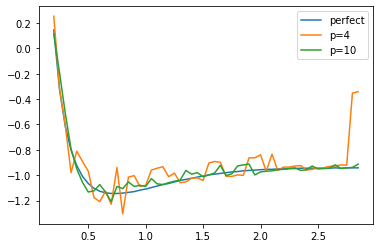

In [10]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
plt.plot(Rs, vals_trotter_4, label="p=4")
plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()